# Background

The data was obtained from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) with a CC0: Public Domain license. The data was inspected, features were created/modified and outliers removed. The created features/modified were:

Created:
- Customer Age
- Total Expenses
- Seniority
- Child Count (Number of Children)
- Has Child (Boolean for children)

Modified:
- Marital Status
- Education

Outliers were removed using scatterplots and boxplots with visual inspection. The prepared data was pickled along with the features to be used for clustering in a list. Pearson correlations were also calculated and the following was determined:

- Income vs Expenses are correlated positively (+0.83)
- Children vs Income (-0.35) and Children vs Expenses (-0.5) are negativly correlated

The rest show little to no correlation. PCA indicated we can remove recency and customer age. Education was also removed due to how it was effecting clustering.

# Goal

Apply K-means and PCA to segment the data based on the features to use excluding recency, customer age and education

# Imports

In [53]:
# data tools
import numpy as np
import pandas as pd
import pickle as pkl


# inspection tools
# from IPython.core.display import HTML
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

# date handling
# import datetime
# from datetime import date

# graphing
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
sns.set()

# machine learning
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import warnings
# warnings.filterwarnings('ignore')

# Functions



In [54]:
# Function to display informative elbow method for clusters

def test_clusters(X, random_state, max_clusters, metric='distortion'):
    model = KMeans(random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    if metric == 'distortion':
        elb_visualiser = KElbowVisualizer(model, k=(1,max_clusters), metric=metric)
    else:
        elb_visualiser = KElbowVisualizer(model, k=(2,max_clusters), metric=metric)
    elb_visualiser.fit(X)
    return elb_visualiser.show()

# Function to display informative silhouette method for clusters

def silhouette_clusters(X, random_state, number_of_clusters):
    model = KMeans(n_clusters=number_of_clusters, random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    
    sil_visualiser = SilhouetteVisualizer(model)
    sil_visualiser.fit(X)
    return sil_visualiser.show()

# Function to perform PCA analysis
def pca_analysis(X, num_components):
    if num_components == 'find':
        pca = PCA()
        pca.fit(X)
    else:
        pca = PCA(n_components=num_components)
        pca.fit(X)
    return pca

# function to get component loadings from PCA
def get_comp_loadings(pca_components, cols, index):
    df_pca_comp = pd.DataFrame(data = pca_components, columns=cols, index = index)
    return df_pca_comp


# Load Data

In [55]:
with open('customer_data_without_outliers.pickle', 'rb') as handle:
    dict = pkl.load(handle)

In [56]:
features = dict['cluster_features']

In [57]:
# Unpack the data
data = dict['data']

#  Select clustering features
segm_data = data[features].copy().drop(["Child_Count",'Customer_Age','Recency', 'Education'], axis = 1)
features = segm_data.columns.tolist()
segm_data

,Marital_Status,Income,Total_Expenses,Seniority,Has_child
ID,,,,,
5524,Alone,58138.0,1617,25.333333,No child
2174,Alone,46344.0,27,7.000000,Has child
4141,Couple,71613.0,776,13.633333,No child
6182,Couple,26646.0,53,7.866667,Has child
5324,Couple,58293.0,422,8.600000,Has child
...,...,...,...,...,...
10870,Couple,61223.0,1341,15.933333,Has child
4001,Couple,64014.0,444,3.866667,Has child
7270,Alone,56981.0,1241,8.400000,No child


In [58]:
# replace boolean versions for children, marital and education

segm_data_temp = segm_data.replace({'Postgraduate': 1,
                               'Undergraduate': 0,
                                'Alone': 0,
                                'Couple': 1,
                                'Has child': 1,
                                'No child': 0})
segm_data_temp

,Marital_Status,Income,Total_Expenses,Seniority,Has_child
ID,,,,,
5524,0,58138.0,1617,25.333333,0
2174,0,46344.0,27,7.000000,1
4141,1,71613.0,776,13.633333,0
6182,1,26646.0,53,7.866667,1
5324,1,58293.0,422,8.600000,1
...,...,...,...,...,...
10870,1,61223.0,1341,15.933333,1
4001,1,64014.0,444,3.866667,1
7270,0,56981.0,1241,8.400000,0


# Create dummy variables

In [59]:
# Get dummies on categorical data
df_dummies = pd.get_dummies(segm_data)
dummy_features = df_dummies.columns.tolist()

# Scale the data

In [60]:
# Use standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)

# Normalisation
X_norm = normalize(X_scaled,norm='l2')

X = X_norm.copy()

# PCA

In [61]:
# get the components
pca = pca_analysis(X, 'find')

#show the number of components
pca.components_.shape

(7, 7)

In [62]:
number_of_components = pca.components_.shape[0]

Text(0, 0.5, 'Cumulative Explained Varience')

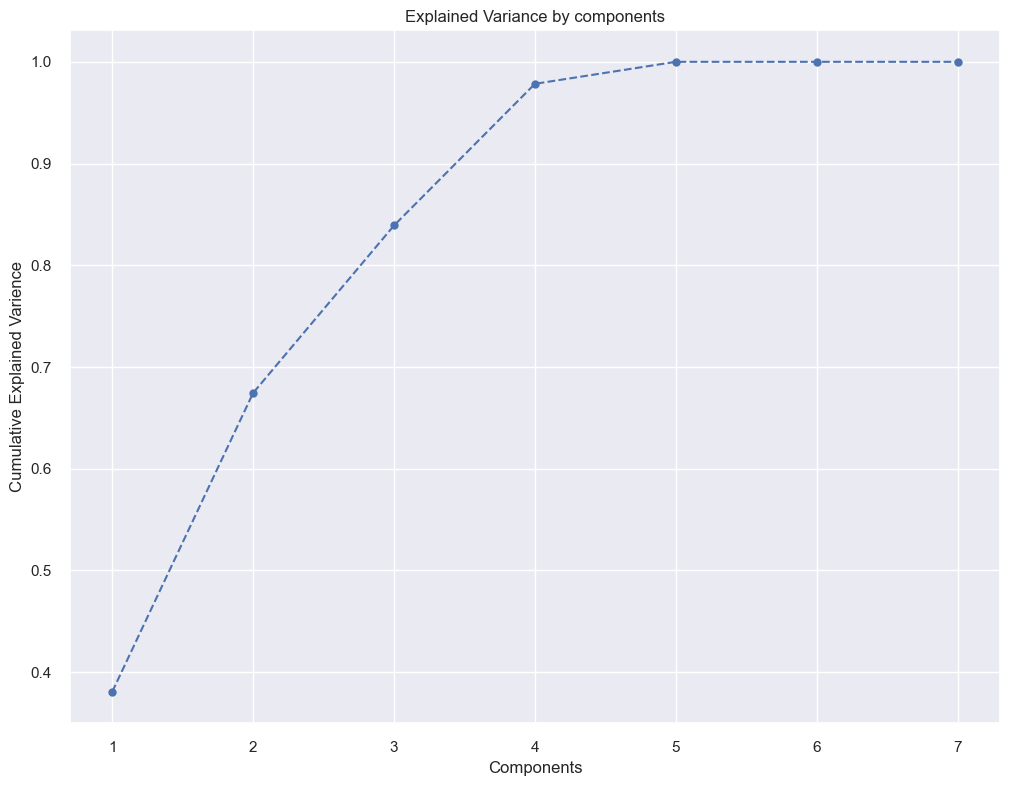

In [63]:
# Plot cumulative variance vs components

plt.figure(figsize=(12,9))
plt.plot(range(1, number_of_components+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title("Explained Variance by components")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Varience")

70-80% Explained varience is a good benchmark, we can reduce the dimensionality to 3 components

In [64]:
Number_of_components_to_use = 3
pca = pca_analysis(X, Number_of_components_to_use)

## PCA Results

In [65]:
pca_comp = get_comp_loadings(pca.components_, dummy_features, ['Component 1', 'Component 2', 'Component 3'])
pca_comp

,Income,Total_Expenses,Seniority,Marital_Status_Alone,Marital_Status_Couple,Has_child_Has child,Has_child_No child
Component 1,0.311942,0.375866,0.052558,0.438257,-0.438257,-0.432734,0.432734
Component 2,-0.351717,-0.354752,-0.029501,0.548182,-0.548182,0.272552,-0.272552
Component 3,0.108082,0.236282,0.912309,0.025102,-0.025102,0.222396,-0.222396


### PCA pearson correlations to features

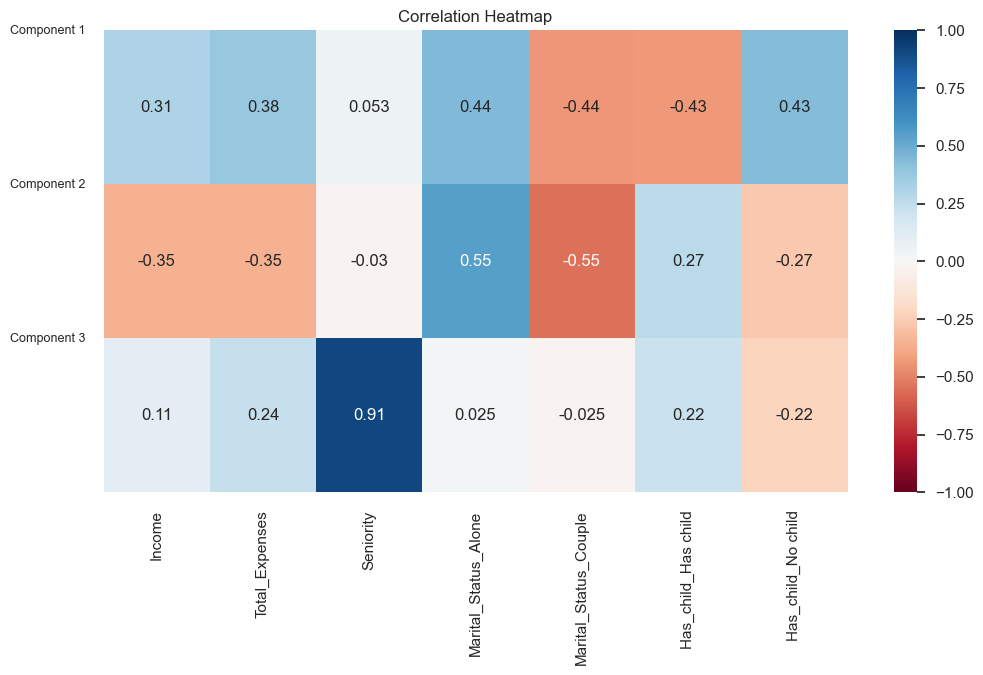

In [66]:
plt.figure(figsize=(12,6))
s = sns.heatmap(pca_comp,
               annot=True,
               cmap='RdBu',
               vmin=-1,
               vmax=1)
plt.yticks([0,1,2], ['Component 1', 'Component 2', 'Component 3'], rotation = 0, fontsize = 9)
plt.title("Correlation Heatmap")
plt.show()

- Component 1 is correlated to Income, Expenses, Marital_Status and Children.
- Component 2 is correlated to Income, Expenses and Marital Status
- Component 3 is correlated to Seniority

In [67]:
# get the PCA scores
scores_pca = pca.transform(X)
scores_pca

array([[ 1.03228414, -0.04961806,  0.30208347],
       [ 0.18074681,  0.86268257, -0.39550277],
       [ 0.54797214, -0.80025602, -0.29937948],
       ...,
       [ 1.03698172,  0.04136283, -0.39814401],
       [-0.30067013, -0.4681006 , -0.25556747],
       [-0.54424011, -0.14631822,  0.61396883]])

# Hierarchical Clustering


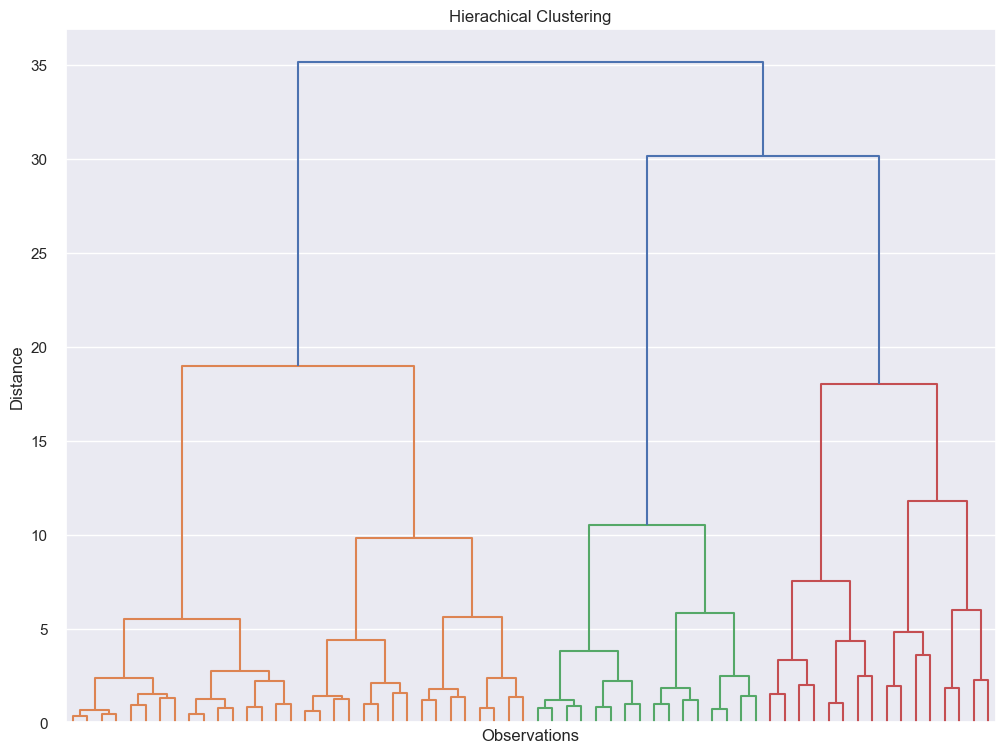

In [68]:
hier_clus = linkage(scores_pca, method='ward')

plt.figure(figsize=(12, 9))
plt.title("Hierachical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clus,
           truncate_mode='level',
           p=5,
           show_leaf_counts=False,
           no_labels=True,
           # color_threshold=0
           )
plt.show()

# K-means
## Choosing number of clusters

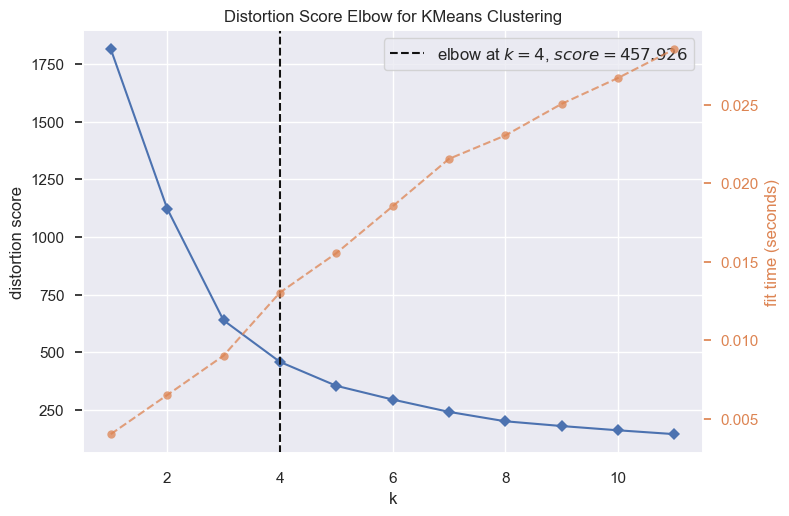

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='distortion')

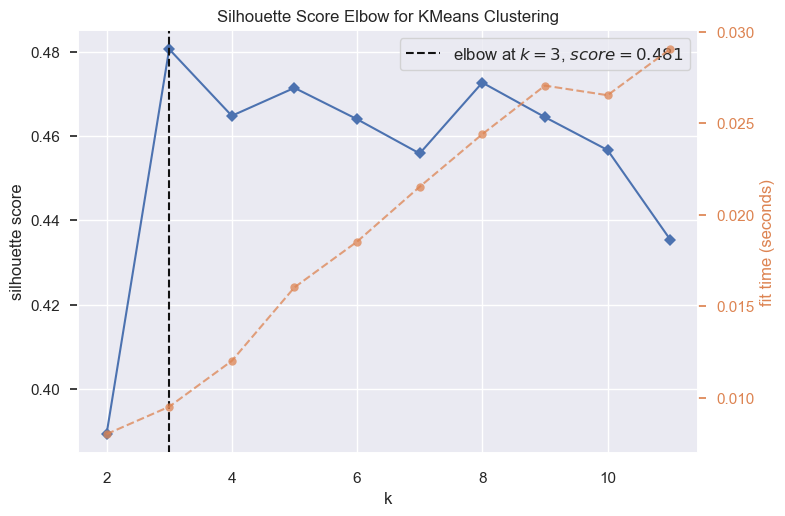

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [70]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='silhouette')

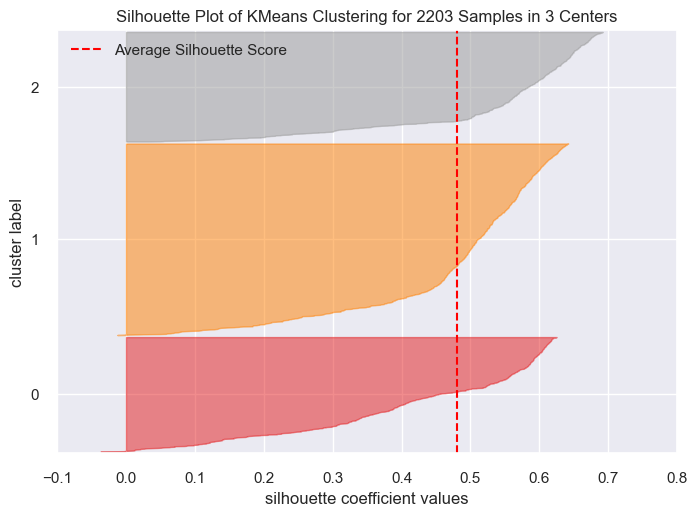

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [72]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=3)

## Cluster selection

The number of clusters to select seem to point to choosing 3 or 4 clusters. The elbow and dendrogram indicate 3 whilst the Silhoette score indicates 4. A simpler model is often best however, previous models suggested 4 clusters. It will ultimatly depend on the interpretability of the X-space. Let's choose for clusters for now and evalute at the end if we need to simplify the model. 


In [73]:
# choose two clusters and fit
num_clusters = 3
kmeans_clus = KMeans(n_clusters=num_clusters, init='k-means++', random_state=1)
kmeans_clus.fit(scores_pca)

KMeans(n_clusters=3, random_state=1)

## Results PCA K-means

In [74]:
# Copying unscaled data and merging with PCA components for 4 clusters
segm_pca_kmeans_clus = pd.concat([df_dummies[dummy_features].reset_index(drop=False),
                                  pd.DataFrame(scores_pca)], axis=1)
segm_pca_kmeans_clus.columns.values[-3:] = ['Component 1',
                                            'Component 2',
                                            'Component 3',
                                            ]

# copy the labels from the models
segm_pca_kmeans_clus['Segment K-means PCA'] = kmeans_clus.labels_


# Calculate the means per cluster
segm_pca_kmeans_clus_means = segm_pca_kmeans_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)


# Calculate the number of observations
segm_pca_kmeans_clus_means['N Obs'] = segm_pca_kmeans_clus[[
    'Segment K-means PCA', 'Income']].groupby(['Segment K-means PCA']).count()


# Calculate the percentage of observations
segm_pca_kmeans_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_clus_means['N Obs']/segm_pca_kmeans_clus_means['N Obs'].sum())*100).round(2)


In [75]:
segm_pca_kmeans_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_clus_means

,Segment K-means PCA,Income,Total_Expenses,Seniority,Marital_Status_Alone,Marital_Status_Couple,Has_child_Has child,Has_child_No child,Component 1,Component 2,Component 3,N Obs,Percent Obs
0,0,69153.881384,1222.378913,15.189676,0.331137,0.668863,0.052718,0.947282,0.667257,-0.478111,-0.113999,607,27.55
1,1,45508.915271,372.478818,14.799770,0.000000,1.000000,0.998030,0.001970,-0.586987,-0.141430,0.035280,1015,46.07
2,2,43963.137694,371.746988,15.250258,1.000000,0.000000,0.913941,0.086059,0.328342,0.746582,0.057467,581,26.37


It seems that the clustering is mainly driven by the dummy variables, we now have seperation in the Income and expense features over the clusters.

- Cluster 0 = Well-off career focused
- Cluster 1 = Family oriented
- Cluster 2 = Single parents


## Rename the segments

In [76]:
segm_pca_kmeans_clus_means.rename({0: 'Well-off career focused',
                                 1: 'Family oriented',
                                 2: 'Single parents',
                               })

,Segment K-means PCA,Income,Total_Expenses,Seniority,Marital_Status_Alone,Marital_Status_Couple,Has_child_Has child,Has_child_No child,Component 1,Component 2,Component 3,N Obs,Percent Obs
Well-off career focused,0,69153.881384,1222.378913,15.189676,0.331137,0.668863,0.052718,0.947282,0.667257,-0.478111,-0.113999,607,27.55
Family oriented,1,45508.915271,372.478818,14.799770,0.000000,1.000000,0.998030,0.001970,-0.586987,-0.141430,0.035280,1015,46.07
Single parents,2,43963.137694,371.746988,15.250258,1.000000,0.000000,0.913941,0.086059,0.328342,0.746582,0.057467,581,26.37


In [30]:
# Map the segments onto observations

In [77]:
segm_data_temp['Labels'] = segm_pca_kmeans_clus['Segment K-means PCA'].map({0: 'Well-off career focused',
                                 1: 'Family oriented',
                                 2: 'Single parents',})

segm_pca_kmeans_clus['Labels'] = segm_pca_kmeans_clus['Segment K-means PCA'].map({0: 'Well-off career focused',
                                 1: 'Family oriented',
                                 2: 'Single parents',})

# Plot the clusters

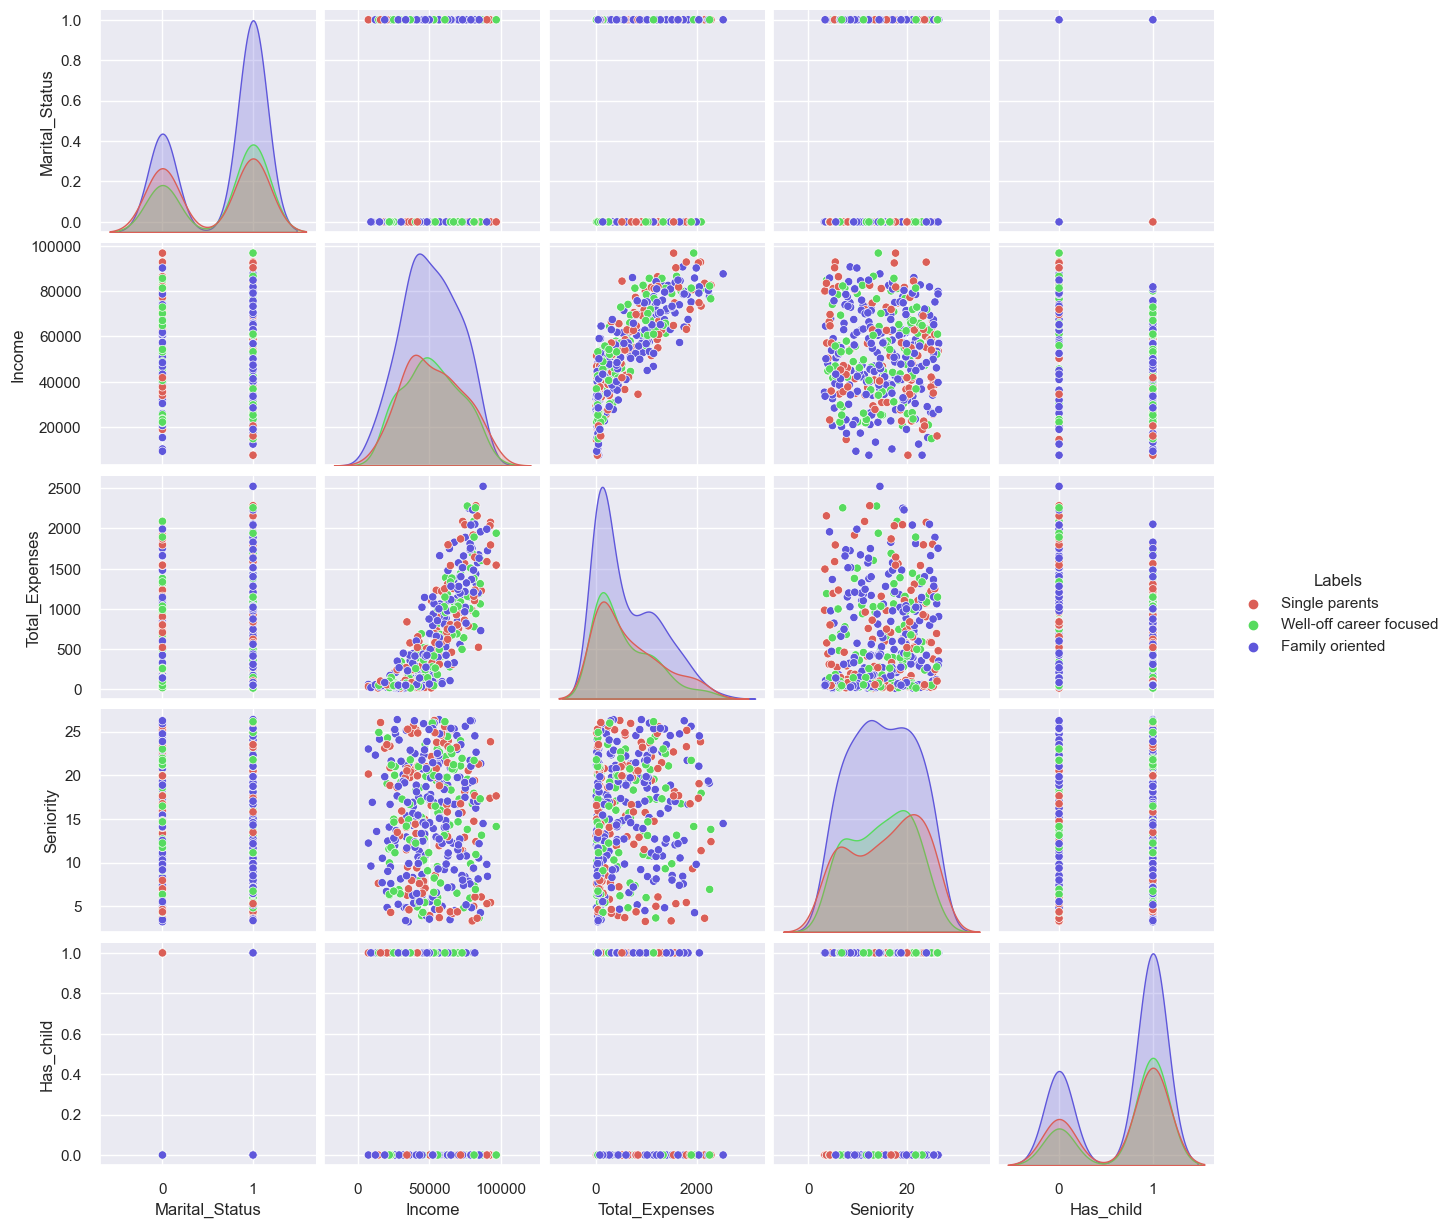

In [78]:
sns.pairplot(segm_data_temp, vars=features, hue='Labels', palette=sns.color_palette('hls',num_clusters))

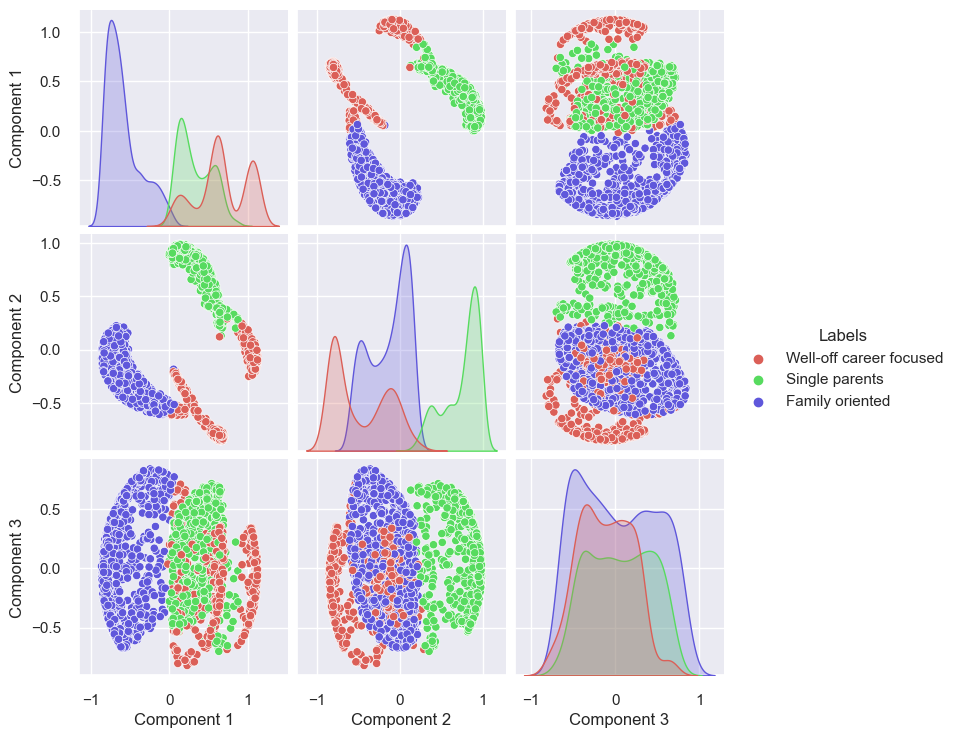

In [79]:
sns.pairplot(segm_pca_kmeans_clus, vars=['Component 1', 'Component 2', 'Component 3'], hue='Labels', palette=sns.color_palette('hls',num_clusters))

# Conclusion

The use of PCA has improved seperation by allowing us to cluster in the z-space. However the interpretability is lost somewhat despite the use of correlations.The x-space is no better resolved. Let us remove marital status